In [23]:

import zipfile
import os
import torch
import torch.nn as nn
import string
import glob
import unicodedata
import random
import matplotlib.pyplot as plt

# Extract data from a ZIP file
zip_file_path = '/content/data (1).zip'
extract_dir = '/content/extracted_data'

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1  # Plus EOS marker

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

def readLines(filename):
    with open(filename, encoding='utf-8') as file:
        return [unicodeToAscii(line.strip()) for line in file]

def findFiles(path):
    return glob.glob(path)

data_directory = '/content/extracted_data/data/names/*.txt'

category_lines = {}
all_categories = []

for filename in findFiles(data_directory):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Use torch.nn.LSTM instead of the self-defined LSTM
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.hidden2output(output.view(1, -1))
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

def randomTrainingPair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

def categoryTensor(category):
    category_index = all_categories.index(category)
    return torch.tensor([category_index], dtype=torch.long)

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS marker
    return torch.tensor(letter_indexes, dtype=torch.long)

def train(category_tensor, input_line_tensor, target_line_tensor, lstm_model, criterion, optimizer):
    target_line_tensor.unsqueeze_(-1)
    hidden = lstm_model.initHidden()
    lstm_model.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = lstm_model(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in lstm_model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

# Training loop
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

lstm_model = LSTMModel(n_letters, 128, n_letters)
criterion = nn.NLLLoss()
learning_rate = 0.0005
optimizer = torch.optim.SGD(lstm_model.parameters(), lr=learning_rate)

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample(), lstm_model, criterion, optimizer)
    total_loss += loss

    if iter % print_every == 0:
        print('Iteration: %d, Loss: %.4f' % (iter, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


Iteration: 5000, Loss: 2.9291
Iteration: 10000, Loss: 3.7369
Iteration: 15000, Loss: 2.6299
Iteration: 20000, Loss: 2.9109
Iteration: 25000, Loss: 2.4023
Iteration: 30000, Loss: 2.5594
Iteration: 35000, Loss: 3.4722
Iteration: 40000, Loss: 3.2730
Iteration: 45000, Loss: 2.5336
Iteration: 50000, Loss: 3.1566
Iteration: 55000, Loss: 2.6131
Iteration: 60000, Loss: 3.2627
Iteration: 65000, Loss: 3.1135
Iteration: 70000, Loss: 2.8779
Iteration: 75000, Loss: 2.8286
Iteration: 80000, Loss: 2.7505
Iteration: 85000, Loss: 2.6966
Iteration: 90000, Loss: 2.9204
Iteration: 95000, Loss: 3.5869
Iteration: 100000, Loss: 2.7576


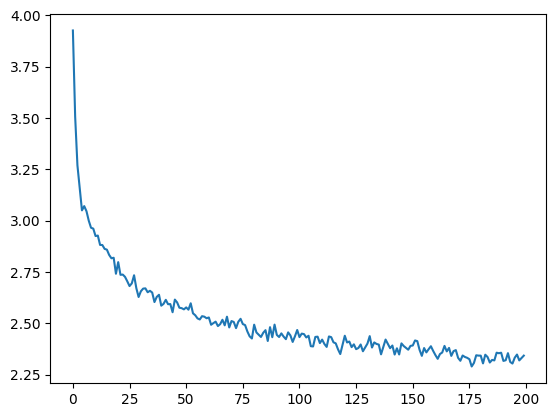

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovaki
Uallan
Shishin
Genter
Eren
Romer
Salla
Paran
Aras
Chan
Han
Iuno
